<div style="text-align: right"> Mark Hendricks </div>

<left>FINM 37500 - Fixed Income Derivatives</left> 
<br>
<left>Winter 2024</left>

<h2><center> Homework #1- Binomial Trees and Black's Formulas </center></h2>

<center>Due: Wednesday, Feb 14 at 6PM</center>

<h3><span style="color:#00008B">Name - Nick Lewis</span></h3>
<h3><span style="color:#00008B">Email - nicklewis16@uchicago.edu</span></h3>

# Homework 1

## FINM 37500: Fixed Income Derivatives

### Mark Hendricks

#### Winter 2024

# Context

For use in these problems, consider the data below, discussed in Veronesi's *Fixed Income Securities* Chapters 9, 10.
* interest-rate tree
* current term structure

In [117]:
import numpy as np
import pandas as pd
import datetime
import warnings
from scipy.optimize import fsolve

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

import sys
sys.path.insert(0, '../cmds')
from binomial import *

In [118]:
rate_tree = pd.DataFrame({0:[.0174,np.nan],0.5:[.0339,.0095]})
rate_tree.columns.name = 'time $t$'
rate_tree.index.name = 'state'
rate_tree.style.format('{:.2%}',na_rep='').format_index('{:.1f}')

time $t$,0.000000,0.500000
state,,
0.0,1.74%,3.39%
1.0,,0.95%


The "tree" is displayed as a pandas dataframe, so it does not list "up" and "down" for the rows but rather an index of nodes. The meaning should be clear.

In [119]:
term_struct = pd.DataFrame({'maturity':[.5,1,1.5],'price':[99.1338,97.8925,96.1462]})
term_struct['continuous ytm'] = -np.log(term_struct['price']/100) / term_struct['maturity']
term_struct.set_index('maturity',inplace=True)
term_struct.style.format({'price':'{:.4f}','continuous ytm':'{:.2%}'}).format_index('{:.1f}')

,price,continuous ytm
maturity,,
0.5,99.1338,1.74%
1.0,97.8925,2.13%
1.5,96.1462,2.62%


This is the current term-structure observed at $t=0$.

# 1. Pricing a Swap

### 1.1 
Calculate the tree of bond prices for the 2-period, $T=1$, bond.



At each node, you calculate the bond price using the formula
$$
P = F e ^{-r(T-t)}
$$
where P is the bond price, F is the face value, r is the interest rate at the node, T is the bond's maturity, and t is the current time node. This directly applies the formula for continuous compounding over the period from t to T.

In [120]:
# Maturity underlying of T = 1, and assuming FV = 100
MATUND = 1.0
FACE= 100

In [121]:
# Initialize the bond price tree
bond_tree = pd.DataFrame(dtype=float, index=rate_tree.index, columns=rate_tree.columns)

# Calculate bond prices using backward induction
for i in bond_tree.columns[-1:0:-1]:
    bond_tree[i] = np.exp(-rate_tree[i] * (MATUND - i)) * FACE
    
    
# Set the initial price based on the quoted price
bond_tree.iloc[0, 0] = term_struct.loc[MATUND, 'price']

# Format and display the bond price tree
display(bond_tree.style.format('{:.4f}').format_index('{:.1f}', axis=1))

time $t$,0.0,0.5
state,,
0,97.8925,98.3193
1,nan,99.5261


### 1.2 
What is the risk-neutral probability of an upward movement of interest rates at $t=.5$?

$$
dt = 0.5\\
A = e^{r_0 \times dt}\\
Z = e^{-r_0 \times dt}
$$

In [122]:
# Given setup
dt = 0.5

# Calculate A and Z
A = np.exp(rate_tree.iloc[0, 0] * dt)
Z = np.exp(-rate_tree.iloc[0, 0] * dt)

In [123]:
# Calculate the risk-neutral probability p*
pstar = (A * bond_tree.loc[0, 0] - bond_tree.loc[1, dt]) / (bond_tree.loc[0, dt] - bond_tree.loc[1, dt])

# Prepare the DataFrame for visualization
pvec = pd.DataFrame([pstar,1-pstar],index=['prob up','prob down'],columns=[''])
pvec.style.format('{:.2%}')

,
prob up,64.49%
prob down,35.51%



## The option contract

Consider a single-period swap that pays at time period 1 ($t=0.5$), the expiration payoff (and thus terminal value) is
* Payoff = $\frac{100}{2}(r_1 −c)$
* with $c=2\%$
* payments are semiannual

Take the viewpoint of a fixed-rate payer, floating rate receiver.


Long a Floating Rate Bond: This bond's value resets at each period based on the prevailing interest rates, making its price at t = 0.5 effectively  100 (ignoring any spread over the reference rate for simplicity).

Short a Fixed Rate Bond: This bond pays a fixed rate c, which is equivalent to the fixed rate of the swap. Since the payments are semiannual, the annualized rate c is applied accordingly.

In [124]:
# Constants
STRIKE = 0.02
FACE = 100
dt = 0.5

# Payoff function for the swap
payoff = lambda r: FACE/2 * (r - STRIKE)

In [125]:
# Initialize the swap tree
swap_tree = pd.DataFrame(index=rate_tree.index, columns=rate_tree.columns, dtype=float)
# Calculate the payoff at t=0.5
swap_tree[dt] = payoff(rate_tree[dt])


### 1.3 
What is the replicating trade using the two bonds (period 1 and period 2)?


In [126]:
def replicating_port(quotes, undertree, derivtree, dt=None, Ncash=100):
    """
    Calculates the replicating portfolio for a derivative given the quotes, undertree, and derivtree.

    Parameters:
    quotes (array-like): The quotes for the derivative.
    undertree (DataFrame): The underlying asset price tree.
    derivtree (DataFrame): The derivative price tree.
    dt (float, optional): The time step size. If not provided, it is calculated from the undertree.
    Ncash (float, optional): The amount of cash to invest. Default is 100.

    Returns:
    DataFrame: The replicating portfolio positions and their values.
    """

    if dt is None:
        dt = undertree.columns[1] - undertree.columns[0]
    
    delta = (derivtree.loc[0, dt] - derivtree.loc[1, dt]) / (undertree.loc[0, dt] - undertree.loc[1, dt]) #matches slope
    cash = (derivtree.loc[0, dt] - delta * undertree.loc[0, dt]) / Ncash # matches intercept
    
    out = pd.DataFrame({'positions': [cash, delta], 'value': quotes}, index=['cash', 'under'])
    out.loc['derivative', 'value'] = out['positions'] @ out['value']
    return out

In [127]:
# Calculate the replicating portfolio
replicating_portfolio = replicating_port(quotes = term_struct.loc[[.5, 1], 'price'].values, 
                                         undertree=bond_tree, derivtree=swap_tree)
replicating_portfolio.style.format('{:.4f}')

,positions,value
cash,1.0009,99.1338
under,-1.0109,97.8925
derivative,nan,0.2595



### 1.4 
What is the price of the swap?

In [128]:
# time 0 price of swap is discount factor * expected value of swap at time 1. Z * (p* swap up + (1-p*) swap down)
swap_tree.loc[0, 0] = Z * np.array([pstar, 1-pstar]) @ swap_tree[dt].values

# Output the swap tree
swap_tree.style.format('{:.4f}').format_index('{:.1f}', axis=1)

time $t$,0.0,0.5
state,,
0,0.2595,0.6950
1,nan,-0.5250


In [129]:
def format_bintree(df, style='{:.2f}'):
    """
    Formats a binary tree represented as a DataFrame.

    Args:
        df (pandas.DataFrame): The binary tree represented as a DataFrame.
        style (str, optional): The formatting style to apply. Defaults to '{:.2f}'.

    Returns:
        pandas.io.formats.style.Styler: The formatted binary tree.
    """
    return df.style.format(style, na_rep='').format_index('{:.2f}', axis=1)

def estimate_pstar(quotes,ratetree,style='european'):
    """
    Estimates the pstar values for each time step in the ratetree.

    Parameters:
    - quotes (DataFrame): DataFrame containing quotes data.
    - ratetree (DataFrame): DataFrame representing the rate tree.
    - style (str): Style of the option (default is 'european').

    Returns:
    - pstars (Series): Series containing the estimated pstar values.
    """
    pstars = pd.Series(dtype=float, index= ratetree.columns[:-1], name='pstar')
    p0 = .5
    
    for steps_forward, t in enumerate(ratetree.columns[1:]):        
        ratetreeT = ratetree.copy().loc[:,:t].dropna(axis=0,how='all')
        t_prev = ratetreeT.columns[steps_forward]
        
        pstars_solved = pstars.loc[:t_prev].iloc[:-1]
        wrapper_fun = lambda p: bond_price_error(quotes['price'].iloc[steps_forward+1], pd.concat([pstars_solved, pd.Series(p,index=[t_prev])]), ratetreeT, style=style)

        pstars[t_prev] = fsolve(wrapper_fun,p0)[0]

    return pstars

def bond_price_error(quote, pstars, ratetree, style='european'):
    """
    Calculates the error between the model price and the given quote for a bond.

    Parameters:
    quote (float): The quoted price of the bond.
    pstars (list): List of probabilities for the binomial tree.
    ratetree (DataFrame): DataFrame representing the interest rate tree.
    style (str, optional): The style of the option. Defaults to 'european'.

    Returns:
    float: The error between the model price and the quote.
    """
    FACEVALUE = 100
    dt = ratetree.columns[1] - ratetree.columns[0]    
    payoff = lambda r: payoff_bond(r,dt)
    modelprice = bintree_pricing(payoff, ratetree, pstars=pstars, style=style).loc[0,0]
    error = modelprice - quote

    return error


def payoff_bond(r, dt, facevalue=100):
    """
    Calculates the payoff of a bond.

    Parameters:
    - r (float): The interest rate.
    - dt (float): The time period.
    - facevalue (float, optional): The face value of the bond. Default is 100.

    Returns:
    - price (float): The calculated bond price.
    """
    price = np.exp(-r * dt) * facevalue
    return price

def bintree_pricing(payoff=None, ratetree=None, undertree=None, cftree=None, dt=None, pstars=None, timing=None, cfdelay=False, style='european', Tamerican=0):
    """
    Calculates the pricing of an option using a binomial tree model.

    Parameters:
    - payoff (function): The payoff function of the option. Default is None.
    - ratetree (DataFrame): The interest rate tree. Default is None.
    - undertree (DataFrame): The underlying asset price tree. Default is None.
    - cftree (DataFrame): The cash flow tree. Default is None.
    - dt (float): The time step size. Default is None.
    - pstars (Series): The probability of up movement in the binomial tree. Default is None.
    - timing (str): The timing of the cash flows. Default is None.
    - cfdelay (bool): Whether to delay the cash flows. Default is False.
    - style (str): The option style. Default is 'european'.
    - Tamerican (float): The time at which the option becomes American style. Default is 0.

    Returns:
    - valuetree (DataFrame): The tree of option values at each node.
    """
    
    if payoff is None:
        payoff = lambda r: 0
    
    if undertree is None:
        undertree = ratetree
        
    if cftree is None:
        cftree = pd.DataFrame(0, index=undertree.index, columns=undertree.columns)
        
    if pstars is None:
        pstars = pd.Series(.5, index=undertree.columns)

    if dt is None:
        dt = undertree.columns.to_series().diff().mean()
        dt = undertree.columns[1]-undertree.columns[0]
    
    if timing == 'deferred':
        cfdelay = True
    
    if dt<.25 and cfdelay:
        display('Warning: cfdelay setting only delays by dt.')
        
    valuetree = pd.DataFrame(dtype=float, index=undertree.index, columns=undertree.columns)

    for steps_back, t in enumerate(valuetree.columns[-1::-1]):
        if steps_back==0:                           
            valuetree[t] = payoff(undertree[t])
            if cfdelay:
                valuetree[t] *= np.exp(-ratetree[t]*dt)
        else:
            for state in valuetree[t].index[:-1]:
                val_avg = pstars[t] * valuetree.iloc[state,-steps_back] + (1-pstars[t]) * valuetree.iloc[state+1,-steps_back]
                
                if cfdelay:
                    cf = cftree.loc[state,t]
                else:                    
                    cf = cftree.iloc[state,-steps_back]
                
                valuetree.loc[state,t] = np.exp(-ratetree.loc[state,t]*dt) * (val_avg + cf)

            if style=='american':
                if t>= Tamerican:
                    valuetree.loc[:,t] = np.maximum(valuetree.loc[:,t],payoff(undertree.loc[:,t]))
        
    return valuetree

# 2. Using the Swap as the Underlying
As in the note, W.1, consider pricing the following interest-rate option,
* Payoff is $100\max(r_K-r_1,0)$
* strike is $r_K$ is 2\%
* expires at period 1, ($t=0.5$) 

Unlike the note, price it with the swap used as the underlying, not the two-period ($t=1$) bond. You will once again use the period-1 ($t=0.5$) bond as the cash account for the no-arbitrage pricing.

So instead of replicating the option with the two treasuries, now you're replicating/pricing it with a one-period bond and two-period swap.

In [130]:
EXPIRATION = .5
STRIKE = .02
payoff = lambda r: FACE * np.maximum(STRIKE - r,0)

### 2.1
Display the tree of swap prices.


In [131]:
swap_tree.style.format('{:.4f}').format_index('{:.1f}', axis=1)

time $t$,0.0,0.5
state,,
0,0.2595,0.6950
1,nan,-0.5250



### 2.2
What is the risk-neutral probability of an upward movement at $t=.5$ implied by the underlying swap tree? 

Is this the same as the risk-neutral probability we found when the bond was used as the underlying?


In [132]:
pstars = estimate_pstar(term_struct.loc[:rate_tree.index[-1], ['price']], rate_tree)
format_bintree(pstars.to_frame().T, style='{:.2%}')

time $t$,0.00
pstar,64.49%



### 2.3
What is the price of the rate option? Is it the same as we calculated in the note, W.1.?

#### Method 1: Direct Calculation Using Swap Tree
Logic is calculating the payoff at expiration and discounting back to the present.

In [133]:
floorlet_tree = pd.DataFrame(dtype=float, columns=rate_tree.columns, index=rate_tree.index)
floorlet_tree[EXPIRATION] = payoff(rate_tree[EXPIRATION])
floorlet_tree.loc[0,0] = Z * np.array([pstar, 1-pstar])@floorlet_tree[EXPIRATION] #discounted expected value
format_bintree(floorlet_tree,style='{:.4f}')

time $t$,0.00,0.50
state,,
0,0.3697,0.0000
1,,1.0500


#### Method 2: Using `bintree_pricing` Function


In [134]:
derivtree = bintree_pricing(payoff, rate_tree, pstars=pstars)
format_bintree(derivtree,style='{:.4f}')

time $t$,0.00,0.50
state,,
0,0.3697,0.0000
1,,1.0500


#### Extension: Replicating Portfolio

In [135]:
replicating_port([term_struct.loc[.5,'price'],swap_tree.loc[0,0]], swap_tree, floorlet_tree, dt=.5).style.format('{:.4f}')

,positions,value
cash,0.0060,99.1338
under,-0.8607,0.2595
derivative,nan,0.3697


# 3. Pricing a Call on a Bond

Try using the same tree to price a call on the period-2 bond, (1-year), at period 1 (6-months).
* Payoff = $\max(P_{1|2}-K,0)$
* Strike = \$99.00


In [136]:
payoff = lambda p: np.maximum(p-STRIKE,0)
STRIKE = 99
EXPIRATION = .5


### 3.1 
What is the replicating trade using the two bonds (period 1 and period 2) as above? (That is, we are no longer using the swap as the underlying.)



### 3.2 
What is the price of the European call option? 
* expiring at $T=.5$ 
* written on the bond maturing in 2 periods, ($t=1$)

In [137]:
pstars = estimate_pstar(term_struct.loc[:rate_tree.index[-1],['price']],rate_tree)
format_bintree(pstars.to_frame().T, style='{:.2%}')

time $t$,0.00
pstar,64.49%


#### Price of Euro Call Option Using Function:

In [138]:
derivtree = bintree_pricing(payoff, rate_tree, undertree=bond_tree, pstars=pstars)
format_bintree(derivtree,style='{:.4f}')

time $t$,0.00,0.50
state,,
0,0.1852,0.0000
1,,0.5261


#### Replicating Portfolio:

In [139]:
replicating_port(term_struct.loc[[.5,1],'price'].values, bond_tree, derivtree, dt=.5).style.format('{:.4f}')

,positions,value
cash,-0.4286,99.1338
under,0.4360,97.8925
derivative,nan,0.1852


# 4 Two-Period Tree

Consider an expanded, **2 period** tree. (Two periods of uncertainty, so with the starting point, three periods total.)

In [140]:
new_col = pd.Series([.05,.0256,.0011],name='1')
rate_tree_multi = pd.concat([rate_tree,new_col],ignore_index=True,axis=1)
rate_tree_multi.columns = pd.Series([0,0.5,1],name='time $t$')
rate_tree_multi.index.name = 'node'
rate_tree_multi.style.format('{:.2%}',na_rep='')

time $t$,0.000000,0.500000,1.000000
node,,,
0,1.74%,3.39%,5.00%
1,,0.95%,2.56%
2,,,0.11%


### 4.1

Calculate and show the tree of prices for the 3-period bond, $T=1.5$.


In [141]:
pstars = estimate_pstar(term_struct,rate_tree_multi)

payoff = lambda r: payoff_bond(r,dt)

bondtree_multi = bintree_pricing(payoff, ratetree=rate_tree_multi, pstars=pstars)
format_bintree(bondtree_multi, style='{:.4f}')

time $t$,0.00,0.50,1.00
node,,,
0,96.1462,96.1426,97.5310
1,,98.5184,98.7282
2,,,99.9450



### 4.2
Report the risk-neutral probability of an up movement at $t=1$.

(The risk-neutral probability of an up movement at $t=0.5$ continues to be as you calculated in 2.3.


In [142]:
format_bintree(pstars.to_frame().T, style='{:.2%}')

time $t$,0.00,0.50
pstar,64.49%,78.69%



### 4.3
Calculate the price of the European **call** option?
* expiring at $T=1$ 
* written on the bond maturing in 3 periods, ($t=1.5$)


Note: Assuming strike = 99

#### Euro Call Price:

In [143]:
STRIKE = 99
call_payoff = lambda p: np.maximum(p - STRIKE,0)

call_derivtree = bintree_pricing(call_payoff, ratetree=rate_tree_multi, undertree = bondtree_multi, pstars=pstars)
format_bintree(call_derivtree, style='{:.4f}')

time $t$,0.00,0.50,1.00
node,,,
0,0.0706,0.0000,0.0000
1,,0.2004,0.0000
2,,,0.9450


#### Euro Put Price:

In [144]:
STRIKE = 99
put_payoff = lambda p: np.maximum(STRIKE-p,0)

put_derivtree = bintree_pricing(put_payoff, ratetree=rate_tree_multi, undertree = bondtree_multi, pstars=pstars)
format_bintree(put_derivtree, style='{:.4f}')

time $t$,0.00,0.50,1.00
node,,,
0,0.8379,1.1935,1.4690
1,,0.2129,0.2718
2,,,0.0000



### 4.4
Consider a finer time grid. Let $dt$ in the tree now be 1/30 instead of 0.5.

Using this smaller time step, compute the $t=0$ price of the following option:
* option expires at $t=1$
* written on bond maturing at $t=1.5

In [145]:
dt = 1/30
pstars = estimate_pstar(term_struct,rate_tree_multi)
payoff = lambda r: payoff_bond(r,dt)
bondtree_multi2 = bintree_pricing(payoff, ratetree=rate_tree_multi, pstars=pstars)
display(format_bintree(bondtree_multi2, style='{:.4f}'))

display(format_bintree(pstars.to_frame().T, style='{:.2%}'))

# ASSUMING CALL OPTION

derivtree2 = bintree_pricing(call_payoff, ratetree=rate_tree_multi, undertree = bondtree_multi2, pstars=pstars)
display(format_bintree(derivtree2, style='{:.4f}'))

time $t$,0.00,0.50,1.00
node,,,
0,97.7749,98.1726,99.8335
1,,99.4585,99.9147
2,,,99.9963


time $t$,0.00,0.50
pstar,64.49%,78.69%


time $t$,0.00,0.50,1.00
node,,,
0,0.8613,0.8365,0.8335
1,,0.9277,0.9147
2,,,0.9963


With a finer time grid, the price of the call option is much more expensive. Compare .5 time grid price of .0706 with the 1/30 time grid price of .8613. Discounting isn't as large of jumps

In [152]:
def exercise_decisions(payoff, undertree, derivtree):
    """
    Determines the exercise decisions for a derivative based on the payoff function, the underlying tree, and the derivative tree.

    Parameters:
    payoff (function): The payoff function that calculates the derivative's payoff based on the underlying tree.
    undertree (numpy.ndarray): The underlying tree.
    derivtree (numpy.ndarray): The derivative tree.

    Returns:
    numpy.ndarray: A boolean array indicating the exercise decisions for the derivative.
    """
    exer = (derivtree == payoff(undertree)) & (derivtree > 0)
    return exer

# 5 American Style
### 5.1
Use the two-period tree from part 4, but this time to price an American-style **put** option.

Use a grid of $dt=.5$.
* What is its value at $t=0$?
* Which nodes would you exercise it early?


#### American Call:

In [151]:
call_am_derivtree = bintree_pricing(call_payoff, ratetree=rate_tree_multi, undertree = bondtree_multi, pstars=pstars, style = 'american')
format_bintree(call_am_derivtree, style='{:.4f}')

time $t$,0.00,0.50,1.00
node,,,
0,0.0706,0.0000,0.0000
1,,0.2004,0.0000
2,,,0.9450


#### American Put:

In [150]:
put_am_derivtree = bintree_pricing(put_payoff, rate_tree_multi, undertree=bondtree_multi, pstars=pstars, style='american')
format_bintree(put_am_derivtree, style='{:.4f}')

time $t$,0.00,0.50,1.00
node,,,
0,2.8538,2.8574,1.4690
1,,0.4816,0.2718
2,,,0.0000


#### Early Exercise:
(Where intrinsic value exceeds continuation value)

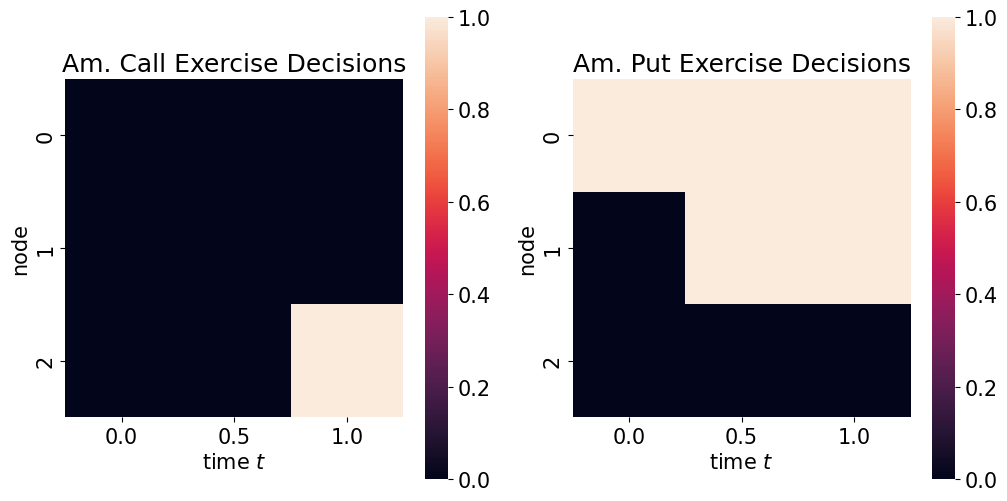

In [158]:
fig, axes = plt.subplots(1, 2)

# Plot the first heatmap
sns.heatmap(exercise_decisions(call_payoff, bondtree_multi, call_am_derivtree), square=True, ax=axes[0])
axes[0].set_title("Am. Call Exercise Decisions")

# Plot the second heatmap
sns.heatmap(exercise_decisions(put_payoff, bondtree_multi, put_am_derivtree), square=True, ax=axes[1])
axes[1].set_title("Am. Put Exercise Decisions")

plt.show()


### 5.2
Change the grid to $dt=1/30$, as in 4.4. 
* What is its value at $t=0$?
* Make a visualization showing which nodes have early exercise. (I suggest using a dataframe and the `heatmap` from `seaborn`.

In [160]:
call_am_derivtree2 = bintree_pricing(call_payoff, ratetree=rate_tree_multi, undertree = bondtree_multi2, pstars=pstars, style = 'american')
format_bintree(call_am_derivtree2, style='{:.4f}')

time $t$,0.00,0.50,1.00
node,,,
0,0.8613,0.8365,0.8335
1,,0.9277,0.9147
2,,,0.9963


In [161]:
put_am_derivtree2 = bintree_pricing(put_payoff, rate_tree_multi, undertree=bondtree_multi2, pstars=pstars, style='american')
format_bintree(put_am_derivtree2, style='{:.4f}')

time $t$,0.00,0.50,1.00
node,,,
0,1.2251,0.8274,0.0000
1,,0.0000,0.0000
2,,,0.0000


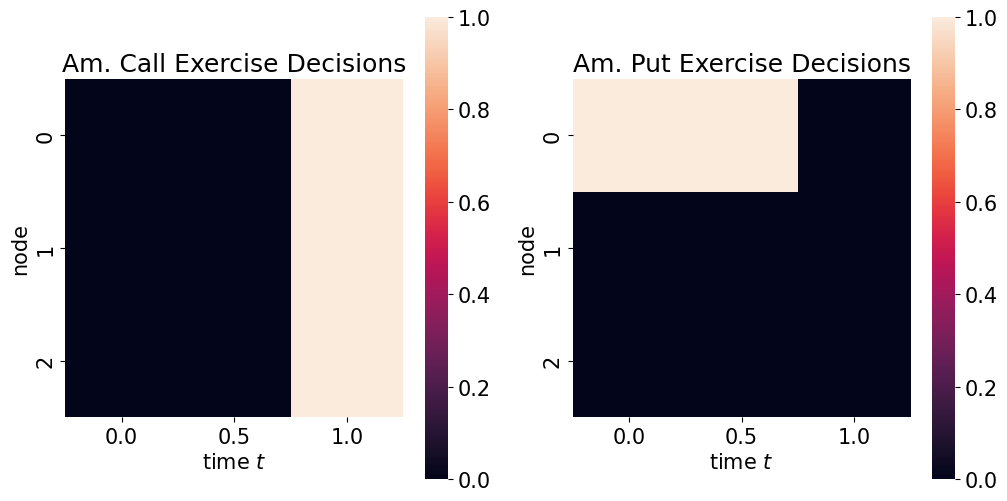

In [163]:
fig, axes = plt.subplots(1, 2)

# Plot the first heatmap
sns.heatmap(exercise_decisions(call_payoff, bondtree_multi2, call_am_derivtree2), square=True, ax=axes[0])
axes[0].set_title("Am. Call Exercise Decisions")

# Plot the second heatmap
sns.heatmap(exercise_decisions(put_payoff, bondtree_multi2, put_am_derivtree2), square=True, ax=axes[1])
axes[1].set_title("Am. Put Exercise Decisions")

plt.show()